## 1. Hipótesis sobre la disposición de las mesas
- Hipótesis nula (H₀): La disposición de las mesas no tiene un efecto significativo en las propinas.
- Hipótesis alternativa (H₁): Una disposición optimizada de las mesas aumenta las propinas.

In [67]:
from src.SimulationEngine import SimulationEngine
from src.RestaurantOptimizer import RestaurantOptimizer 
import json
import os
import time

# Obtener la ruta absoluta al directorio que contiene tu script
dir_path = os.getcwd()

# Usar la ruta absoluta para abrir el archivo config.json
with open(os.path.join(dir_path, 'config.json')) as f:
    config = json.load(f)


In [2]:
def optimize_random_layout():
    start_time = time.time()

    for _ in range(5):
        simulation_engine = SimulationEngine(
            duration=config['simulation_duration'],
            arrival_rate=config['arrival_rate'],
            waiter_amount=config['number_of_waiters']
        )

        optimizer = RestaurantOptimizer(
            simulation_engine=simulation_engine,
            initial_temp=config['initial_temp'],
            final_temp=config['final_temp'],
            alpha=config['alpha'],
            max_iter=config['max_iter'],
            nights_per_layout=config['nights_per_layout'],
            initial_grid=config['optimizer_grid'],
            num_tables=config['number_of_tables'],
            rules_priority=config['rules_priority']
        )

        best_config, best_tips, best_waiting_time, init_tips, init_wait = optimizer.simulated_annealing()
        print("Mejor configuración:")
        for row in best_config:
            print(row)
        print("Mejor promedio de propinas por noche:", best_tips)
        print("Mejor promedio de waiting time por noche:", best_waiting_time)

        end_time = time.time()
        print("Total execution time: {} seconds".format(end_time - start_time), "\n")

        return init_tips, init_wait, best_tips, best_waiting_time

In [ ]:
import scipy.stats as stats

# Datos de ejemplo
initial_setup_times = []  # Tiempos de servicio en minutos
optimized_setup_times = []

initial_tips = []  # Propinas en dólares
optimized_tips = []

for _ in range(5):
    init_tips, init_wait, best_tips, best_waiting_time = optimize_random_layout()
    initial_setup_times.append(init_wait)
    optimized_setup_times.append(best_waiting_time)

    initial_tips.append(init_tips)
    optimized_tips.append(best_tips)

# Realizar el t-test para los tiempos de servicio
service_time_ttest = stats.ttest_ind(initial_setup_times, optimized_setup_times)
print(f"T-test para tiempos de servicio: estadístico={service_time_ttest.statistic}, p-valor={service_time_ttest.pvalue}")

# Realizar el t-test para las propinas
tips_ttest = stats.ttest_ind(initial_tips, optimized_tips)
print(f"T-test para propinas: estadístico={tips_ttest.statistic}, p-valor={tips_ttest.pvalue}")

# # Interpretar los resultados
alpha = 0.05

if tips_ttest.pvalue < alpha:
    print("Rechazamos la hipótesis nula para las propinas: la disposición optimizada tiene un efecto significativo.")
else:
    print("No podemos rechazar la hipótesis nula para las propinas.")

## 2. Hipótesis sobre la distribución normal de las propinas
- Hipótesis nula (H₀): Las propinas parecen seguir una distribución normal.
- Hipótesis alternativa (H₁): Las propinas no siguen una distribución normal.

In [7]:
from src.utils.utils import PlaceType  
import random

def fill_initial_grid(grid, num_tables):
    rows, cols = len(grid), len(grid[0]) 
    tables_positions = []
    empty_positions = []

    available_positions = [[1 for _ in range(cols)] for _ in range(rows)] 

    for row in range(rows):
        for col in range(cols):
            cell = grid[row][col]

            if cell == PlaceType.WALL:
                available_positions[row][col] = 0
            elif cell in (PlaceType.TABLE, PlaceType.ENTRY_DOOR, PlaceType.KITCHEN):
                for dr in [-1, 0, 1]:
                    for dc in [-1, 0, 1]:
                        nr, nc = row + dr, col + dc
                        if 0 <= nr < rows and 0 <= nc < cols:
                            available_positions[nr][nc] = 0

    for row in range(rows):
        for col in range(cols):
            if available_positions[row][col]:
                empty_positions.append((row, col))  

    while len(tables_positions) < num_tables:
        r, c = random.choice(empty_positions) 
        grid[r][c]=PlaceType.TABLE 
        tables_positions.append((r,c))

        for dr in [-1, 0, 1]:
            for dc in [-1, 0, 1]:
                if dr==0 and dc==0:
                    continue

                nr, nc = r + dr, c + dc
                if (nr,nc) in empty_positions:
                    empty_positions.remove((nr,nc))


In [83]:
import pandas as pd

columnas = ['grid', 'rules_priority', 'waiter_amount', 'table_amount' , 'tips']
df = pd.DataFrame(columns=columnas)

In [76]:
import random

def gen_random_layout():
    duration = 3600
    arrival_rate = 0.003
    waiter_amount = random.randint(1,5)
    simulation_engine = SimulationEngine(
        duration=duration,
        arrival_rate=arrival_rate,
        waiter_amount=waiter_amount,
        verbose = False
    )
    table_amount = random.randint(4,10)
    grid = copy.deepcopy(config['optimizer_grid'])
    fill_initial_grid(grid, table_amount)

    rules_priority = config["rules_priority"]
    rule_copy = copy.deepcopy(rules_priority)
    random.shuffle(rule_copy)
    
    total_tips = 0
    nights_per_layout = 50
    
    for _ in range(nights_per_layout):
        simulation_tips, total_waiting_time = simulation_engine.run(grid, rules_priority)
        total_tips += simulation_tips
        # print("propina: ", simulation_tips)

    
    average_tips = total_tips / nights_per_layout
    df.loc[len(df)]={'grid': grid, 'rules_priority': rule_copy, 'waiter_amount': waiter_amount, 'table_amount':table_amount, 'tips':average_tips}
    
    return average_tips
    # print("Promedio de propinas:", average_tips)

In [94]:
for i in range(400):
    gen_random_layout()

KeyboardInterrupt: 

In [92]:
import pandas as pd
from scipy import stats

# Suponiendo que ya tienes el DataFrame cargado
# df = pd.read_csv('tu_archivo.csv') # Si estás cargando desde un archivo

# Aplicar el test de Shapiro-Wilk a la columna 'tips'
stat, p_value = stats.shapiro(df['tips'])

# Mostrar los resultados
print(f'Estadístico de Shapiro-Wilk: {stat}')
print(f'P-valor: {p_value}')

# Evaluar si la distribución es normal o no
alpha = 0.05
if p_value > alpha:
    print("No se puede rechazar la hipótesis nula: las propinas parecen seguir una distribución normal.")
else:
    print("Se rechaza la hipótesis nula: las propinas no siguen una distribución normal.")


Estadístico de Shapiro-Wilk: 0.9739493533878445
P-valor: 0.0010358363762985544
Se rechaza la hipótesis nula: las propinas no siguen una distribución normal.


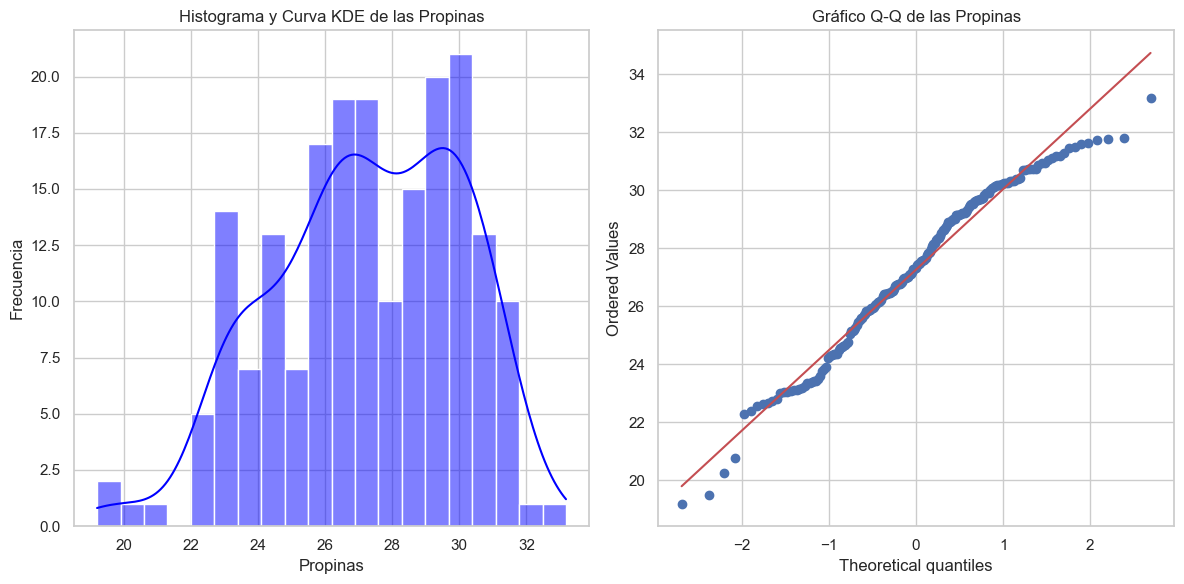

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Suponiendo que ya tienes el DataFrame cargado
# df = pd.read_csv('tu_archivo.csv') # Si estás cargando desde un archivo

# Configuración de estilo
sns.set(style="whitegrid")

# Crear figura para los dos gráficos
plt.figure(figsize=(12, 6))

# Subplot 1: Histograma con curva KDE
plt.subplot(1, 2, 1)
sns.histplot(df['tips'], kde=True, bins=20, color='blue')
plt.title('Histograma y Curva KDE de las Propinas')
plt.xlabel('Propinas')
plt.ylabel('Frecuencia')

# Subplot 2: Q-Q plot
plt.subplot(1, 2, 2)
stats.probplot(df['tips'], dist="norm", plot=plt)
plt.title('Gráfico Q-Q de las Propinas')

# Mostrar gráficos
plt.tight_layout()
plt.show()


## 3.Hipotesis sobre la correlacion entre la cercania de las mesas y la suma de propinas

- Hipótesis Nula (H₀): No existe relación entre la distancia a la cocina y la cantidad de propinas, o si existe, no es negativa.
- Hipótesis Alternativa (H₁): Existe una relación negativa entre la distancia a la cocina y la suma de propinas (es decir, a mayor distancia de la cocina, menor propina).

In [103]:
tips=df['tips']
dist=[]

for i in range(len(df)):
    grid = df.iloc[i]['grid']

    rows=len(grid)
    cols=len(grid[0])
    tables=[]
    kitchen=(0,0)
    for i in range(rows):
        for j in range(cols):
            if(grid[i][j]==PlaceType.TABLE):
                tables.append((i,j))
            elif(grid[i][j]==PlaceType.KITCHEN):
                kitchen=(i,j)

    s = 0 
    
    for table in tables:
        s += abs(table[0]-kitchen[0])
        s += abs(table[1]-kitchen[1])
 
    dist.append(s)

# print(tips)
# print(dist)


0      27.266116
1      29.506678
2      27.272329
3      29.740062
4      26.990507
         ...    
555    24.614979
556    32.201598
557    29.229697
558    28.457998
559    29.207217
Name: tips, Length: 560, dtype: float64
[51, 42, 51, 37, 34, 43, 63, 38, 65, 23, 30, 27, 49, 53, 45, 54, 32, 54, 26, 51, 50, 29, 54, 38, 49, 30, 52, 59, 62, 37, 57, 44, 36, 35, 26, 48, 39, 46, 32, 27, 44, 27, 52, 58, 52, 56, 21, 34, 53, 32, 44, 30, 21, 52, 18, 50, 33, 27, 41, 44, 29, 19, 52, 31, 58, 26, 45, 30, 29, 57, 25, 38, 38, 35, 16, 36, 36, 33, 27, 55, 55, 35, 33, 23, 28, 48, 25, 44, 23, 47, 42, 21, 50, 45, 45, 20, 37, 30, 73, 54, 37, 46, 44, 31, 43, 26, 44, 36, 50, 25, 44, 47, 49, 40, 31, 28, 44, 36, 50, 34, 47, 36, 63, 43, 57, 63, 39, 48, 47, 59, 41, 50, 47, 32, 28, 51, 55, 37, 42, 52, 51, 46, 27, 38, 25, 57, 39, 28, 31, 25, 56, 50, 56, 45, 41, 42, 28, 42, 48, 31, 62, 29, 33, 43, 36, 39, 32, 18, 61, 71, 50, 55, 39, 32, 43, 26, 55, 42, 35, 38, 40, 50, 51, 56, 55, 54, 39, 50, 48, 36, 39, 45, 58, 

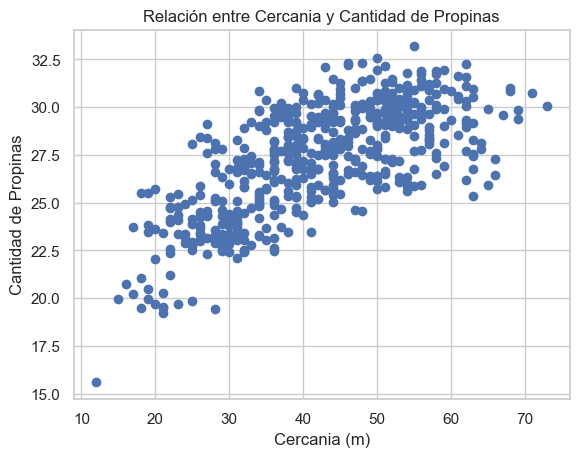

Coeficiente de correlación de Pearson: 0.7120262163489829
P-valor: 9.639618318240736e-88
Se rechaza la hipótesis nula: Existe una relación significativa entre la altura y la cantidad de mangos.
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     573.8
Date:                Mon, 14 Oct 2024   Prob (F-statistic):           9.64e-88
Time:                        14:47:35   Log-Likelihood:                -1190.5
No. Observations:                 560   AIC:                             2385.
Df Residuals:                     558   BIC:                             2394.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                

In [105]:

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Ejemplo de datos: altura (en metros) y cantidad de mangos
dist = np.array(dist)  # alturas de las matas de mango
tips = np.array(tips)  # cantidad de mangos producidos

# Visualizamos los datos
plt.scatter(dist, tips)
plt.title('Relación entre Cercania y Cantidad de Propinas')
plt.xlabel('Cercania (m)')
plt.ylabel('Cantidad de Propinas')
plt.show()

# Correlación de Pearson
corr_coef, p_value = stats.pearsonr(dist, tips)

print(f'Coeficiente de correlación de Pearson: {corr_coef}')
print(f'P-valor: {p_value}')

# Hipótesis: Si p_value < 0.05, se rechaza la hipótesis nula.
alpha = 0.05
if p_value < alpha:
    print('Se rechaza la hipótesis nula: Existe una relación significativa entre la altura y la cantidad de mangos.')
    if corr_coef < 0:
        print('La relación es negativa.')
else:
    print('No se puede rechazar la hipótesis nula: No hay evidencia de una relación significativa.')

# Regresión lineal
X = sm.add_constant(dist)  # Añadimos una constante para la intersección
modelo = sm.OLS(tips, X).fit()
print(modelo.summary())